# SOC model
In CityLearn 2022, there are only two observations that actually depend on the action: the battery's state of charge and the total net energy consumption.
The goal of this subproject is to explicitly learn these relationships in an efficient way. Having access to this partial model of the environment will help a lot.

The other variables of the model will be modelled separately.

First, we need to collect samples from the environment. Then we need to learn the relationship, and we need a way to quantify the uncertainty.
This is a simple reinforcement learning problem in itself, with the objective of minimizing prediction error across the entire state space.
We are interested in the following model:

inputs:
* SOC
* solar production
* electric load
* action taken

outputs:
* next SOC
* next net_electricity_use

Open questions:
- [ ] how much harder would it be to learn this in conjunction with the rest of the state space?
- [ ] how do we keep track of uncertainty? some RL algorithms do this implicitly.
- [ ] it would be more plausible to learn this offline. Let's do that!

## 1. Collecting samples
for this, we use an existing agent, for example LudwigRBC. We collect and store the observation-action pairs in a list.

In [15]:
import numpy as np
import pandas as pd
saved_states = []
saved_actions = []

In [16]:
import numpy as np
import time
# RandomAgent specified elsewhere
from agents.orderenforcingwrapper import OrderEnforcingAgent
from citylearn.citylearn import CityLearnEnv

class Constants:
    episodes = 1
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'

def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict

def evaluate():
    print("Starting local evaluation")
    
    env = CityLearnEnv(schema=Constants.schema_path)
    agent = OrderEnforcingAgent()

    obs_dict = env_reset(env)

    agent_time_elapsed = 0

    step_start = time.perf_counter()
    actions = agent.register_reset(obs_dict)
    agent_time_elapsed += time.perf_counter()- step_start

    episodes_completed = 0
    num_steps = 0
    interrupted = False
    episode_metrics = []
    saved_actions.append(actions)
    saved_states.append(obs_dict["observation"])
    try:
        while True:
            observations, reward, done, _ = env.step(actions)

            if done:
                episodes_completed += 1
                metrics_t = env.evaluate()
                metrics = {"price_cost": metrics_t[0], "emmision_cost": metrics_t[1]}
                if np.any(np.isnan(metrics_t)):
                    raise ValueError("Episode metrics are nan, please contant organizers")
                episode_metrics.append(metrics)
                print(f"Episode complete: {episodes_completed} | Latest episode metrics: {metrics}", )

                obs_dict = env_reset(env)

                step_start = time.perf_counter()
                actions = agent.register_reset(obs_dict)
                agent_time_elapsed += time.perf_counter()- step_start
            else:
                step_start = time.perf_counter()
                actions = agent.compute_action(observations)
                agent_time_elapsed += time.perf_counter()- step_start
            
            saved_states.append(observations)
            saved_actions.append(actions)

            num_steps += 1
            if num_steps % 1000 == 0:
                print(f"Num Steps: {num_steps}, Num episodes: {episodes_completed}")

            if episodes_completed >= Constants.episodes:
                break
    except KeyboardInterrupt:
        print("========================= Stopping Evaluation =========================")
        interrupted = True
    
    if not interrupted:
        print("=========================Completed=========================")

    if len(episode_metrics) > 0:
        print("Average Price Cost:", np.mean([e['price_cost'] for e in episode_metrics]))
        print("Average Emmision Cost:", np.mean([e['emmision_cost'] for e in episode_metrics]))
        print("Average of both costs:", (np.mean([e['price_cost'] for e in episode_metrics]) + np.mean([e['emmision_cost'] for e in episode_metrics]))/2)
    print(f"Total time taken by agent: {agent_time_elapsed}s")
    

if __name__ == '__main__':
    complete_start = time.perf_counter()
    evaluate()
    print("The entire evaluation took: {elapsed}s".format(elapsed = (time.perf_counter()- complete_start)))

Starting local evaluation
Num Steps: 1000, Num episodes: 0
Num Steps: 2000, Num episodes: 0
Num Steps: 3000, Num episodes: 0
Num Steps: 4000, Num episodes: 0
Num Steps: 5000, Num episodes: 0
Num Steps: 6000, Num episodes: 0
Num Steps: 7000, Num episodes: 0
Num Steps: 8000, Num episodes: 0
Episode complete: 1 | Latest episode metrics: {'price_cost': 1.3359152127789933, 'emmision_cost': 1.9327180585814085}
=========================Completed=========================
Average Price Cost: 1.3359152127789933
Average Emmision Cost: 1.9327180585814085
Average of both costs: 1.634316635680201
Total time taken by agent: 1.0314060310058721s
The entire evaluation took: 4.909681500000033s


In [26]:
data_obs = np.array(saved_states)[:,:,(20,21,22,23)] # select variables of interest: load, solar, soc, net_electricity_consumption
data_act = np.array(saved_actions)
print(data_obs.shape)
print(data_act.shape)

# i=0
# data = pd.DataFrame(data_obs[:, i, :], columns=["load", "solar", "soc", "net_electricity_use"])
# data["building_id"] = i
# data.head()

(8760, 5, 4)
(8760, 5, 1)


## 2. Learning from samples
First, we inspect the data manually, looking at how well it covers the state and action spaces, and see if we can already spot patterns.
Then, we select a model and train it.

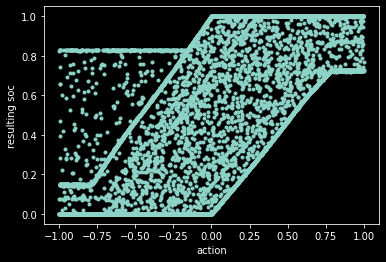

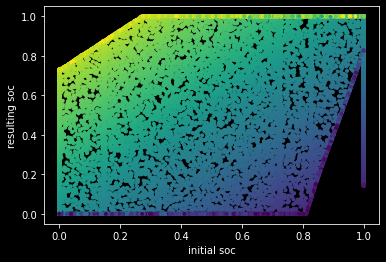

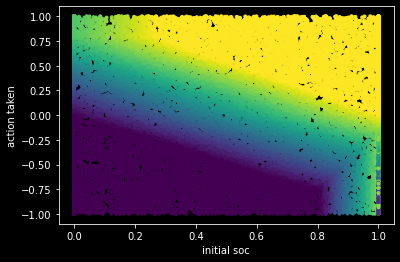

In [27]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.scatter(x=data_act[:-1,0],y=data_obs[1:, 0, 2], marker=".")
plt.xlabel("action")
plt.ylabel("resulting soc")
plt.show()

plt.scatter(x=data_obs[:-1,:,2],y=data_obs[1:, :, 2], c=data_act[:-1,:], marker=".")
plt.xlabel("initial soc")
plt.ylabel("resulting soc")
plt.show()

plt.scatter(x=data_obs[:-1,:,2], y=data_act[:-1,:],c=data_obs[1:, :, 2], marker=".")
plt.xlabel("initial soc")
plt.ylabel("action taken")
plt.show()

In [5]:
# let's learn to predict the next SOC with a simple linear regression!
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
X = np.stack((data_obs[:-1,:,(2)], data_act[:-1,:,0]), axis=2) # soc, action taken
print(X.shape)
y = data_obs[1:,:,(2)] # next soc
X = X.reshape((-1,2))
y = y.reshape((-1,1))

reg = reg.fit(X=X, y=y)
print("predictive power of SOC and the action:",reg.coef_)
print("linear model correlation: ", reg.score(X,y))


# maybe a tree-based method works better
from sklearn import tree

treemodel = tree.DecisionTreeRegressor(min_samples_leaf=1)
treemodel = treemodel.fit(X,y)
print("Decision tree feature importance: SOC, action", treemodel.feature_importances_)
print("Decision tree score:", treemodel.score(X,y))

(8759, 5, 2)
predictive power of SOC and the action: [[0.56467651 0.51268057]]
linear model correlation:  0.8657490632085809
Decision tree feature importance: SOC, action [0.35803314 0.64196686]
Decision tree score: 0.9999635178712885


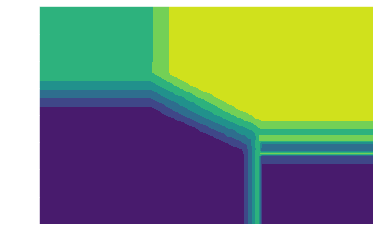

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay
#plt.show(DecisionBoundaryDisplay.from_estimator(reg, X))
DecisionBoundaryDisplay.from_estimator(treemodel, X)

In [12]:

treemodel.predict(np.array([[0.95,-1]],dtype=np.float32))

array([0.60864436])

In [ ]:
# let's try to predict the next net_electricity_use with a simple linear regression!
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
X = np.concatenate((data_obs[:-1,:,(0,1,2)], data_act[:-1]), axis=2) # load, solar, soc, action taken
y = data_obs[1:,:,(3)] # next electricity use 
X = X.reshape((-1,4))
y = y.reshape((-1,1))

reg.fit(X=X, y=y)
print(reg.coef_)
print(reg.score(X,y))


[[ 0.9459105  -1.04090983 -0.4959936   4.45614885]]
0.34482008373901885
